In [1]:
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
disasters = pd.read_csv('clean_train.csv')
stop = stopwords.words('english')

#Si no encuentra "stopwords"
#import nltk
#nltk.download('stopwords')

## Analisis de los datos

In [ ]:
disasters.info()

### Agregamos columnas utiles para analizar el set de datos

#### Caracteristicas del texto

In [ ]:
disasters['text_word_count'] = disasters.text.str.count(' ') + 1
disasters['text_total_len'] = disasters.text.str.len()
disasters['text_stripped_len'] = disasters.text.str.replace(' ', '').str.len()
disasters['text_word_length_avg'] = disasters.text_stripped_len/disasters.text_word_count
disasters['text_without_stopwords'] = disasters['text'].apply(lambda x: " ".join([item for item in x.lower().split() if item not in stop]))

#### Hashtags

In [ ]:
disasters['hashtags'] = disasters.text.str.findall(r'#(\w+)').apply(' '.join).str.lower()
disasters['hashtags_count'] = disasters.hashtags.str.count(' ') + 1

#### Mentions

In [ ]:
disasters['mentions'] = disasters.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(' '.join).str.lower()
disasters['mentions_count'] = disasters.mentions.str.count(' ') + 1

#### URLs

In [ ]:
disasters['urls'] = disasters.text.str.findall(r'(https?://[^\s]+)').apply(' '.join)
disasters['urls_count'] = disasters.urls.str.count(' ') + 1

In [ ]:
urls = pd.DataFrame(" ".join(disasters['urls']).split(), columns=['url'])
urls.drop_duplicates(inplace=True)

In [ ]:
disaster_urls = " ".join(disasters.loc[disasters['target'] == 1]['urls']).split()
non_disaster_urls = " ".join(disasters.loc[disasters['target'] == 0]['urls']).split()

In [ ]:
urls['frequency_on_disasters'] = urls.url.apply(lambda x: disaster_urls.count(x))
urls['frequency_on_non_disasters'] = urls.url.apply(lambda x: non_disaster_urls.count(x))
urls['total_frequency'] = urls['frequency_on_disasters'] + urls['frequency_on_non_disasters']

## Graficos

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func
from PIL import Image
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sns.set(style="whitegrid")

#### Distribucion de target

In [ ]:
disasters['urls_count'].value_counts()

In [ ]:
disasters['hashtags_count'].value_counts().sort_index()

In [ ]:
disasters['mentions_count'].value_counts()

In [ ]:
d11 = disasters.loc[disasters['target'] == 0]['hashtags_count'].value_counts().sort_index()
d12 = disasters.loc[disasters['target'] == 0]['mentions_count'].value_counts().sort_index()
d13 = disasters.loc[disasters['target'] == 0]['urls_count'].value_counts().sort_index()
d21 = disasters.loc[disasters['target'] == 1]['hashtags_count'].value_counts().sort_index()
d22 = disasters.loc[disasters['target'] == 1]['mentions_count'].value_counts().sort_index()
d23 = disasters.loc[disasters['target'] == 1]['urls_count'].value_counts().sort_index()

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,5))
a11 = sns.barplot(x=d11.index, y=d11, ax=axs[0][0], palette=sns.color_palette("RdBu", n_colors=d11.index.shape[0], desat=0.4))
a11.set_yscale("log")
a11.set_ylabel("")
a12 = sns.barplot(x=d12.index, y=d12, ax=axs[0][1], palette=sns.color_palette("BrBG", n_colors=d12.index.shape[0], desat=0.4))
a12.set_yscale("log")
a12.set_ylabel("")
a13 = sns.barplot(x=d13.index, y=d13, ax=axs[0][2], palette=sns.color_palette("Blues_d", n_colors=d13.index.shape[0], desat=0.4))
a13.set_yscale("log")
a13.set_ylabel("")

a21 = sns.barplot(x=d21.index, y=d21, ax=axs[1][0], palette=sns.color_palette("RdBu", n_colors=d21.index.shape[0]))
a21.set_yscale("log")
a21.set_ylabel("")
a22 = sns.barplot(x=d22.index, y=d22, ax=axs[1][1], palette=sns.color_palette("BrBG", n_colors=d22.index.shape[0]))
a22.set_yscale("log")
a22.set_ylabel("")
a23 = sns.barplot(x=d23.index, y=d23, ax=axs[1][2], palette=sns.color_palette("Blues_d", n_colors=d23.index.shape[0]))
a23.set_yscale("log")
a23.set_ylabel("")

fig.suptitle('Distribucion de la cantidad de hashtags, menciones y URLs en los tweets (escala logaritmica)')
fig.text(0, 0.75, 'Tweets no desastre', ha='center')
fig.text(0, 0.25, 'Tweets desastre', ha='center')

fig.text(0.24, 0, 'Cant. de #hashtags', ha='center')
fig.text(0.51, 0, 'Cant. de @menciones', ha='center')
fig.text(0.79, 0, 'Cant. de URLs', ha='center')

fig.savefig('plots/clasificacion_tweets.png')

fig.subplots_adjust(hspace=0.5, left=0.1)

In [ ]:
def showValuesOnBars(axs, h_v="v", space=0.4, color="#000000", fontsize=12):
    def showOnSinglePlot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", color=color, fontsize=fontsize) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - 0.2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", color=color, fontsize=fontsize)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            showOnSinglePlot(ax)
    else:
        showOnSinglePlot(axs)

In [ ]:
def getMostCommonValue(x):
    return x[0]

def getMostCommonFreq(x):
    return x[1]

disaster_hashtags = " ".join(disasters.loc[disasters['target'] == 1, 'hashtags'])
non_disaster_hashtags = " ".join(disasters.loc[disasters['target'] == 0, 'hashtags'])

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(13,7))
f.subplots_adjust(wspace=0)

#Hashtags comunes para los desastres
disasters_most_common_hashtags = Counter(disaster_hashtags.split()).most_common(15)
top_15_used_hashtags_in_disasters = pd.DataFrame({
            'word':list(map(getMostCommonValue, disasters_most_common_hashtags)), 
            'freq':list(map(getMostCommonFreq, disasters_most_common_hashtags))
        })

plt_top_15_used_hashtags_in_disasters = sns.barplot(x='freq', y='word', data=top_15_used_hashtags_in_disasters, orient='h', ax=axes[0],
                                                    palette=sns.cubehelix_palette(start=2.5, rot=-0.2, dark=0.3, n_colors=15, reverse=True)
                                                   )
plt_top_15_used_hashtags_in_disasters.set_xlabel('')
plt_top_15_used_hashtags_in_disasters.set_ylabel('Hashtag')
plt_top_15_used_hashtags_in_disasters.set(title="Tweets desastres")

plt_top_15_used_hashtags_in_disasters.set(xlim=(0, 60))
plt_top_15_used_hashtags_in_disasters.invert_xaxis()

showValuesOnBars(plt_top_15_used_hashtags_in_disasters, "h", -0.25, "w")

#Hashtags comunes para los no desastres
non_disasters_most_common_hashtags = Counter(non_disaster_hashtags.split()).most_common(15)
top_15_used_hashtags_in_non_disasters = pd.DataFrame({
            'word':list(map(getMostCommonValue, non_disasters_most_common_hashtags)), 
            'freq':list(map(getMostCommonFreq, non_disasters_most_common_hashtags))
        })

plt_top_15_used_hashtags_in_non_disasters = sns.barplot(x='freq', y='word', data=top_15_used_hashtags_in_non_disasters, orient='h', ax=axes[1], 
                                                    palette=sns.cubehelix_palette(start=0.75, rot=-0.2, dark=0.3, n_colors=15, reverse=True)
                                                   )
plt_top_15_used_hashtags_in_non_disasters.set_xlabel('')
plt_top_15_used_hashtags_in_non_disasters.set_ylabel('')
plt_top_15_used_hashtags_in_non_disasters.set(title="Tweets no-desastres")

plt_top_15_used_hashtags_in_non_disasters.set(xlim=(0, 60))

plt_top_15_used_hashtags_in_non_disasters.yaxis.tick_right()

showValuesOnBars(plt_top_15_used_hashtags_in_non_disasters, "h", -2.5, "w")

sns.despine(left=True, bottom=True)
f.suptitle('Los 15 #hashtags mas usados')
f.text(0.5, 0.04, 'Cantidad de veces usado', ha='center')

f.savefig('plots/top_15_hashtags.png')

In [ ]:
temp1 = disasters.loc[disasters['target'] == 1].hashtags.str.split(expand=True).stack().value_counts().reset_index()
temp2 = disasters.loc[disasters['target'] == 0].hashtags.str.split(expand=True).stack().value_counts().reset_index()
mixed_hashtags = temp1.merge(temp2, on='index', how='inner')
mixed_hashtags.columns = ['hashtag', 'disasters_frequency', 'non_disaster_frequency']
mixed_hashtags['total_frequency'] = mixed_hashtags['disasters_frequency'] + mixed_hashtags['non_disaster_frequency']

duplicated_top_15 = mixed_hashtags.sort_values(by='total_frequency', ascending=False).head(15)

bar_color = "g"

f, ax = plt.subplots(figsize=(8, 8))
sns.set_color_codes("pastel")
tot_hashtags = sns.barplot(x="total_frequency", y="hashtag", data=duplicated_top_15, label="En todos los tweets", color=bar_color)

sns.set_color_codes("muted")
dis_hashtags = sns.barplot(x="disasters_frequency", y="hashtag", data=duplicated_top_15, label="En tweets de desastres", color=bar_color)

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 80), ylabel="#Hashtag", xlabel="Cantidad de hashtags", title="Los 15 #hashtags mas utilizados en ambos tipos de tweet")

sns.despine(left=True, bottom=True)

showValuesOnBars(tot_hashtags, "h", 0.15, "#292922")

f.savefig('plots/top_15_hashtags_repetidos.png')

plt.show()

In [ ]:
disaster_mentions = " ".join(disasters.loc[disasters['target'] == 1, 'mentions'])
non_disaster_mentions = " ".join(disasters.loc[disasters['target'] == 0, 'mentions'])

f, axes = plt.subplots(1, 2, figsize=(13,7))
f.subplots_adjust(wspace=0)

#Menciones comunes para los desastres
disasters_most_common_mentions = Counter(disaster_mentions.split()).most_common(15)
top_15_used_mentions_in_disasters = pd.DataFrame({
            'word':list(map(getMostCommonValue, disasters_most_common_mentions)), 
            'freq':list(map(getMostCommonFreq, disasters_most_common_mentions))
        })

plt_top_15_used_mentions_in_disasters = sns.barplot(x='freq', y='word', data=top_15_used_mentions_in_disasters, orient='h', ax=axes[0],
                                                    palette=sns.cubehelix_palette(start=2.5, rot=-0.2, dark=0.3, n_colors=15, reverse=True)
                                                   )
plt_top_15_used_mentions_in_disasters.set_xlabel('')
plt_top_15_used_mentions_in_disasters.set_ylabel('Cuenta')
plt_top_15_used_mentions_in_disasters.set(title="Tweets desastres")

plt_top_15_used_mentions_in_disasters.set(xlim=(0, 60))
plt_top_15_used_mentions_in_disasters.invert_xaxis()

showValuesOnBars(plt_top_15_used_mentions_in_disasters, "h", -0.25, "w")

#Menciones comunes para los no desastres
non_disasters_most_common_mentions = Counter(non_disaster_mentions.split()).most_common(15)
top_15_used_mentions_in_non_disasters = pd.DataFrame({
            'word':list(map(getMostCommonValue, non_disasters_most_common_mentions)), 
            'freq':list(map(getMostCommonFreq, non_disasters_most_common_mentions))
        })

plt_top_15_used_mentions_in_non_disasters = sns.barplot(x='freq', y='word', data=top_15_used_mentions_in_non_disasters, orient='h', ax=axes[1], 
                                                    palette=sns.cubehelix_palette(start=0.75, rot=-0.2, dark=0.3, n_colors=15, reverse=True)
                                                   )
plt_top_15_used_mentions_in_non_disasters.set_xlabel('')
plt_top_15_used_mentions_in_non_disasters.set_ylabel('')
plt_top_15_used_mentions_in_non_disasters.set(title="Tweets no-desastres")

plt_top_15_used_mentions_in_non_disasters.set(xlim=(0, 70))

plt_top_15_used_mentions_in_non_disasters.yaxis.tick_right()

showValuesOnBars(plt_top_15_used_mentions_in_non_disasters, "h", -2.5, "w")

sns.despine(left=True, bottom=True)
f.suptitle('Las 15 cuentas mas @mencionadas')
f.text(0.5, 0.04, 'Cantidad de veces mencionada', ha='center')

f.savefig('plots/top_15_menciones.png')

In [ ]:
temp1 = disasters.loc[disasters['target'] == 1].mentions.str.split(expand=True).stack().value_counts().reset_index()
temp2 = disasters.loc[disasters['target'] == 0].mentions.str.split(expand=True).stack().value_counts().reset_index()
mixed_mentions = temp1.merge(temp2, on='index', how='inner')
mixed_mentions.columns = ['mention', 'disasters_frequency', 'non_disaster_frequency']
mixed_mentions['total_frequency'] = mixed_mentions['disasters_frequency'] + mixed_mentions['non_disaster_frequency']

duplicated_top_15 = mixed_mentions.sort_values(by='total_frequency', ascending=False).head(15)

bar_color = "b"

f, ax = plt.subplots(figsize=(8, 8))
sns.set_color_codes("pastel")
tot_mentions = sns.barplot(x="total_frequency", y="mention", data=duplicated_top_15, label="En todos los tweets", color=bar_color)

sns.set_color_codes("muted")
dis_mentions = sns.barplot(x="disasters_frequency", y="mention", data=duplicated_top_15, label="En tweets de desastres", color=bar_color)

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 90), ylabel="@Cuenta", xlabel="Cantidad de menciones", title="Las 15 cuentas mas @mencionadas en ambos tipos de tweet")

sns.despine(left=True, bottom=True)

showValuesOnBars(tot_mentions, "h", 0.15, "b")

f.savefig('plots/top_15_menciones_repetidas.png')

plt.show()

In [ ]:
mentions = pd.DataFrame(" ".join(disasters['mentions']).split(), columns=['mention'])
mentions.drop_duplicates(inplace=True)

disaster_mentions = " ".join(disasters.loc[disasters['target'] == 1]['mentions']).split()
non_disaster_mentions = " ".join(disasters.loc[disasters['target'] == 0]['mentions']).split()

mentions['frequency_on_disasters'] = mentions.mention.apply(lambda x: disaster_mentions.count(x))
mentions['frequency_on_non_disasters'] = mentions.mention.apply(lambda x: non_disaster_mentions.count(x))
mentions['total_frequency'] = mentions['frequency_on_disasters'] + mentions['frequency_on_non_disasters']

In [ ]:
plot_data = mentions.sort_values(by='total_frequency', ascending=False).head(15)

f, ax = plt.subplots(figsize=(8, 8))
sns.set_color_codes("pastel")
tot_mentions = sns.barplot(x="total_frequency", y="mention", data=plot_data, label="En todos los tweets", color="b")

sns.set_color_codes("muted")
dis_mentions = sns.barplot(x="frequency_on_disasters", y="mention", data=plot_data, label="En tweets de desastres", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 90), ylabel="Cuenta", xlabel="Cantidad de menciones", title="Las 15 cuentas mas @mencionadas")

sns.despine(left=True, bottom=True)

showValuesOnBars(tot_mentions, "h", 0.15, "b")

f.savefig('plots/top_15_menciones_2.png')

plt.show()

In [ ]:
plot_data = urls.sort_values(by='total_frequency', ascending=False).head(15)

links_description = {
    "http://t.co/qew4c5M1xd": "Preparacion de emergencia ante un tornado",
    "http://t.co/eNCmhz6y34": "Sitio de batalla de fans (Fan Army)",
    "http://t.co/q2eBlOKeVE": "Portal billboard.com",
    "http://t.co/KSAwlYuX02": "Nota sobre una autoinmolacion de un Pakistani de 16 años",
    "http://t.co/vVPLFQv58P": "Busqueda de imagenes en Daum (Google sur-coreano) sobre el Escuadron 731",
    "http://t.co/cybKsXHF7d": "Video de la llegada de un Tsunami a EEUU",
    "http://t.co/thoYhrHkfJ": "Portal billboard.com",
    "https://t.co/rqWuoy1fm4": "Tweet contra Assad por usar bombas contra refugiados Sirios",
    "http://t.co/vIwXY1XDYK": "Sitio que fomenta contra los asesinatos masivos",
    "http://t.co/o91f3cYy0R": "Sitio de batalla de fans (Fan Army)",
    "http://t.co/LvlH3W3aWO": "Articulo sobre el miedo de los parientes de una victima de un asesinato en masa a que se repita otro",
    "http://t.co/WvJ39a3BGM": "Sitio de batalla de fans (Fan Army)",
    "https://t.co/moLL5vd8yD": "Archivo inexistente de Google",
    "http://t.co/zujwUiomb3": "Link a producto de Ebay",
    "http://t.co/nnMQlz91o9": "Portal billboard.com",
}

f, ax = plt.subplots(figsize=(9, 5))
sns.set_color_codes("pastel")
tot = sns.barplot(x="total_frequency", y="url", data=plot_data, label="En todos los tweets", color="r")

sns.set_color_codes("muted")
dis = sns.barplot(x="frequency_on_disasters", y="url", data=plot_data, label="En tweets de desastres", color="r")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 10), ylabel="URL", xlabel="Cantidad de referencias", title="Las 15 URLs mas referenciadas")
sns.despine(left=True, bottom=True)

showValuesOnBars(tot, "h", 0.15, "r")

f.savefig('plots/top_15_urls.png')

plt.show()

In [ ]:
temp1 = disasters.loc[disasters['target'] == 1].urls.str.split(expand=True).stack().value_counts().reset_index()
temp2 = disasters.loc[disasters['target'] == 0].urls.str.split(expand=True).stack().value_counts().reset_index()
mixed_urls = temp1.merge(temp2, on='index', how='inner')
mixed_urls.columns = ['url', 'disasters_frequency', 'non_disaster_frequency']
mixed_urls['total_frequency'] = mixed_urls['disasters_frequency'] + mixed_urls['non_disaster_frequency']
mixed_urls

### Wordclouds

In [ ]:
disaster_mentions = " ".join(disasters.loc[disasters['target'] == 1, 'mentions'])
non_disaster_mentions = " ".join(disasters.loc[disasters['target'] == 0, 'mentions'])

In [ ]:
#Funciones de ayuda para colorear los wordcloud por clase
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [ ]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

temp_mask = np.array(Image.open("hashtag_mask.png"))
hashtag_mask = np.ndarray((temp_mask.shape[0],temp_mask.shape[1]), np.int32)

for i in range(len(temp_mask)):
    hashtag_mask[i] = list(map(transform_format, temp_mask[i]))

In [ ]:
hashtags_wc = WordCloud(collocations=False, font_path='BebasNeue-Regular.ttf', mask=hashtag_mask, width=1000, height=500, max_font_size=70, max_words=300, background_color="white").generate(disaster_hashtags + " " + non_disaster_hashtags)

hashtag_colors = {
    '#2D574E': list(map(lambda x: x, disaster_hashtags.split())),
    '#673F59': list(map(lambda x: x, non_disaster_hashtags.split()))
}

hashtags_wc.recolor(color_func=GroupedColorFunc(hashtag_colors, 'black'))

hashtags_wc.to_file("plots/hashtags_wc.png")

plt.imshow(hashtags_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
mention_mask = np.array(Image.open("twitter_mask.png"))

mentions_wc = WordCloud(collocations=False, font_path='BebasNeue-Regular.ttf', mask=mention_mask, width=1000, height=500, max_font_size=70, max_words=400, background_color="white").generate(disaster_mentions + " " + non_disaster_mentions)

mention_colors = {
    '#2D574E': list(map(lambda x: x, disaster_mentions.split())),
    '#673F59': list(map(lambda x: x, non_disaster_mentions.split()))
}

mentions_wc.recolor(color_func=GroupedColorFunc(mention_colors, 'black'))

mentions_wc.to_file("plots/mentions_wc.png")

plt.imshow(mentions_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Ciudad y Pais

In [61]:
sns.set_style("white")

In [3]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [4]:
geom = [Point(xy) for xy in zip(disasters['lon'], disasters['lat'])]
gdf = GeoDataFrame(disasters, geometry=geom)

In [80]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

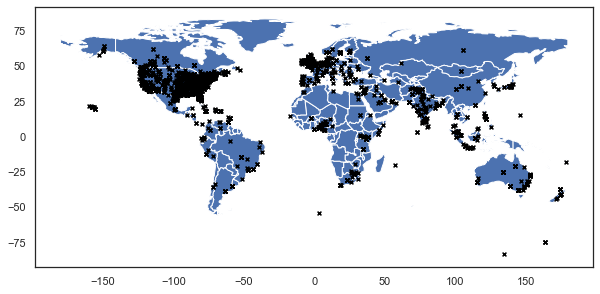

In [81]:
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='x', color="#000000", markersize=15);

In [82]:
countries = disasters.loc[disasters['country'] != 'undefined']['country'].value_counts().reset_index()
countries.columns = ['name', 'tweets_qty']
countries['name'].replace({'United States':'United States of America'}, inplace=True)

In [84]:
worldTweets = world.merge(countries, how='left', on='name')
worldTweets.loc[worldTweets['tweets_qty'].isna(), ['tweets_qty']] = 0
worldTweets['tweets_qty_log'] = np.log(worldTweets['tweets_qty'])

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

divide by zero encountered in log



In [91]:
worldTweets.loc[worldTweets['tweets_qty_log'] == -np.inf, ['tweets_qty_log']] = 0.0

[]

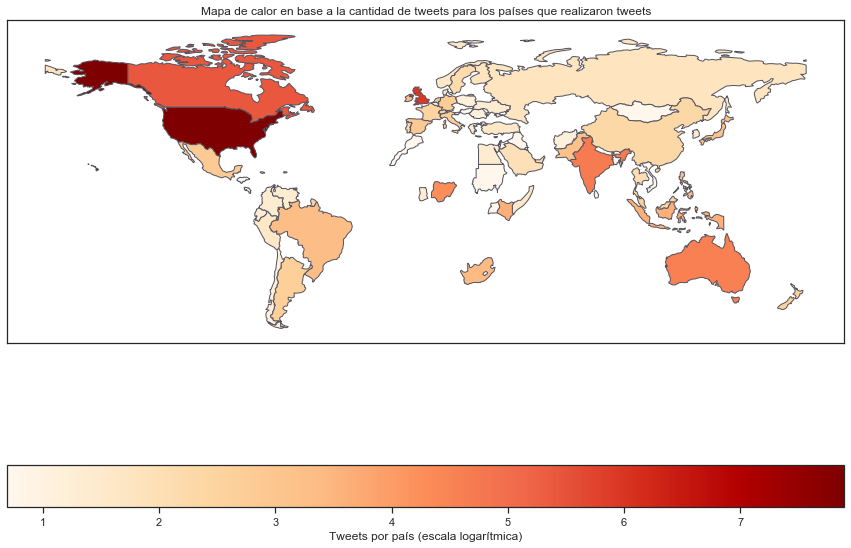

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
worldTweets.loc[worldTweets['tweets_qty_log'] != 0].plot(column='tweets_qty_log', cmap='OrRd', edgecolor='#545460', ax=ax, legend=True, legend_kwds={'label': "Tweets por país (escala logarítmica)", 'orientation': "horizontal"})
ax.set_title("Mapa de calor en base a la cantidad de tweets para los países que realizaron tweets")
ax.set_yticklabels([])
ax.set_xticklabels([])

In [63]:
countries

,name,tweets_qty
0,United States of America,2682
1,United Kingdom,396
2,Canada,220
3,India,111
4,Australia,99
...,...,...
128,Saipan,1
129,Palestine,1
130,Syria,1
131,what street #,1
